In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
import scipy.stats as sts
pd.set_option('display.max_columns', 50)
from matplotlib.ticker import FormatStrFormatter
sns.set_style(style='whitegrid')

In [2]:
train = pd.read_csv('train_def_bis.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('test_def_bis.csv').drop('Unnamed: 0', axis=1)

In [3]:
test16 = pd.read_csv('test16.csv').drop('Unnamed: 0', axis=1)
test17 = pd.read_csv('test17.csv').drop('Unnamed: 0', axis=1)
test19 = pd.read_csv('test19.csv').drop('Unnamed: 0', axis=1)
test20 = pd.read_csv('test20.csv').drop('Unnamed: 0', axis=1)

In [4]:
train.shape

(1208, 35)

# Features transformation

In [5]:
features = list(train.iloc[:, 1:].columns)
cat_list = list(train.loc[:, 'College/University':'area_8'].columns)
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]
X_test16 = test16.iloc[:, 1:]
X_test17 = test17.iloc[:, 1:]
X_test19 = test19.iloc[:, 1:]
X_test20 = test20.iloc[:, 1:]

y_train = train['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values
y_test = test['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values
y_test16 = test16['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values
y_test17 = test17['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values
y_test19 = test19['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values
y_test20 = test20['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values

In [6]:
def log_transform(x):
    return np.log(x + 1)
def square_transform(x):
    return x**2
def identity(x):
    return x

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
transformer_log = FunctionTransformer(log_transform)
transformer_square = FunctionTransformer(square_transform)
transformer_id = FunctionTransformer(identity)
transformer_poly = PolynomialFeatures()
scaler = StandardScaler()


In [8]:
# Transformation des features
numeric_preprocessor = Pipeline(steps=[('transformer', transformer_log), ('scaler', scaler)])
discret_preprocessor = Pipeline(steps=[('transformer', transformer_square), ('scaler', scaler)])
discret_preprocessor2 = Pipeline(steps=[('scaler', scaler)])
cat_preprocessor = Pipeline(steps=[('transformer', transformer_id)])
poly_preprocessor = Pipeline(steps=[('transformer', transformer_poly), ('scaler', scaler)])
preprocessor = ColumnTransformer([('numerical', numeric_preprocessor, ['PropertyGFATotal', 'PropertyGFAParking']), 
                                  ('discret', discret_preprocessor, ['building_age']), 
                                  ('poly', transformer_poly, ['NumberofBuildings', 'NumberofFloors']),
                                  ('categorical', cat_preprocessor, cat_list)])
preprocessor1 = ColumnTransformer([('numerical', numeric_preprocessor, ['PropertyGFATotal', 'PropertyGFAParking']), 
                                  ('discret', discret_preprocessor, ['building_age', 'NumberofBuildings', 'NumberofFloors']), 
                                  ('categorical', cat_preprocessor, cat_list)])
preprocessor2 = ColumnTransformer([('numerical', numeric_preprocessor, ['PropertyGFATotal', 'PropertyGFAParking']), 
                                 ('discret', discret_preprocessor2, ['building_age', 'NumberofBuildings', 'NumberofFloors']), 
                                  ('categorical', cat_preprocessor, cat_list)])

In [9]:
features2 = []
for i in range(len(preprocessor2.transformers)):
    features2 += preprocessor2.transformers[i][2]

# Différents modèles
## Dummy regression

In [10]:
from sklearn.dummy import DummyRegressor
import time

dummy = DummyRegressor(strategy='mean')
pipe1 = make_pipeline(preprocessor, dummy)

start1 = time.process_time() 
pipe1.fit(X_train, y_train)
time1 = time.process_time() - start1 

print(f"Score for train set dummy regression : {dummy.score(X_train, y_train)} - Fit time : {time1}")
print(f"Score for test set dummy regression : {dummy.score(X_test, y_test)}")
result1 = [round(dummy.score(X_train, y_train), 3), round(time1, 4), round(dummy.score(X_test, y_test), 3)]

Score for train set dummy regression : 0.0 - Fit time : 0.02134199999999975
Score for test set dummy regression : -0.0017864552251956045


## Linear regression 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

estimator2 = LinearRegression()
pipe2 = make_pipeline(preprocessor2, estimator2)
cv_results2 = cross_validate(pipe2, X_train, y_train, cv=cv, scoring='r2')
pipe2.fit(X_train, y_train);

In [12]:
print(f"Mean test score for the cross validation  : {cv_results2['test_score'].mean()} - Mean fit time : {cv_results2['fit_time'].mean()}")
print(f"Score for test set Linear regression : {pipe2.score(X_test, y_test)}")
result2 = [round(cv_results2['test_score'].mean(), 3), round(cv_results2['fit_time'].mean(), 4), round(pipe2.score(X_test, y_test), 3)]

Mean test score for the cross validation  : 0.7361436201805744 - Mean fit time : 0.014941930770874023
Score for test set Linear regression : 0.7351047276048914


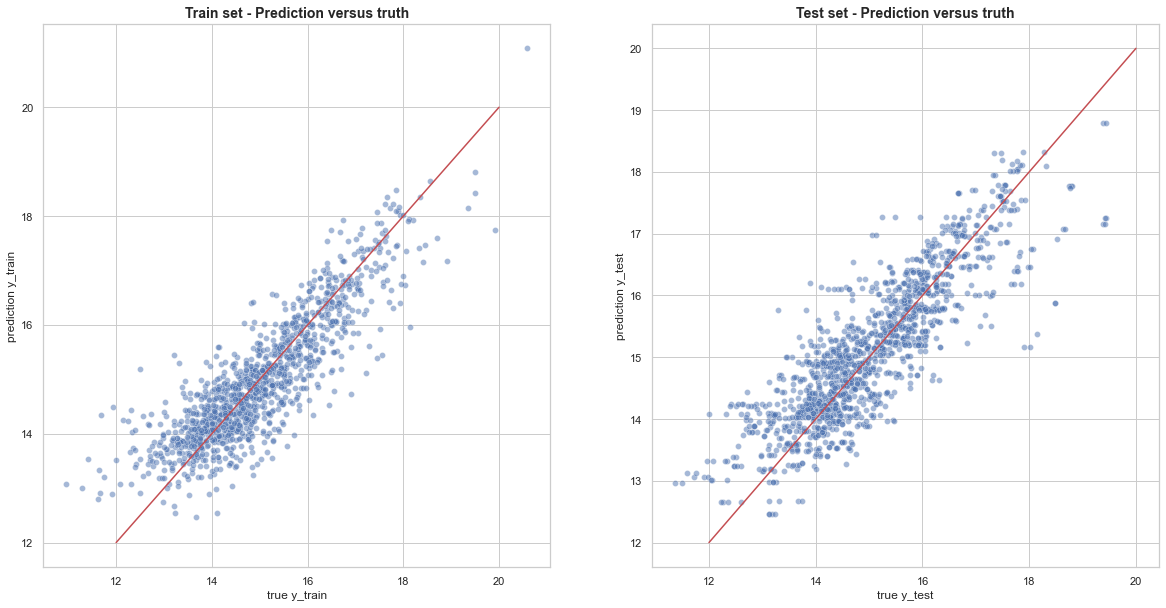

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train, y=pipe2.predict(X_train), alpha=0.5)
sns.lineplot(ax=ax[0], x=[12, 20], y=[12, 20], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test, y=pipe2.predict(X_test), alpha=0.5)
sns.lineplot(ax=ax[1], x=[12, 20], y=[12, 20], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');

In [14]:
fig.get_figure().savefig('linear_regression.pdf')

## Ridge

In [15]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
n_alphas = 200
alphas = {'ridge__alpha':list(np.linspace(0.1, 0.8, n_alphas))}

estimator3 = Ridge()
pipe3 = make_pipeline(preprocessor2, estimator3)


#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search3 = GridSearchCV(pipe3, param_grid=alphas, n_jobs=1, cv=cv, scoring='r2')
grid_search3.fit(X_train, y_train)
results3=pd.DataFrame(grid_search3.cv_results_)
best_score3 = max(results3['mean_test_score'])

fit_time3  = results3.loc[results3['mean_test_score']==best_score3, 'mean_fit_time'].values

In [16]:
print(f"Best mean test score : {best_score3} - Mean fit time : {fit_time3} - With the parameter : {grid_search3.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search3.predict(X_test))}")
result3 = [round(best_score3, 3), round(fit_time3[0], 4), round(r2_score(y_test, grid_search3.predict(X_test)), 3)]

Best mean test score : 0.73889468892793 - Mean fit time : [0.01075988] - With the parameter : {'ridge__alpha': 0.4095477386934674}
Test set score : 0.7356838091111726


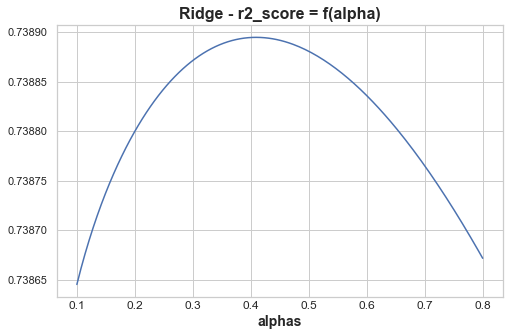

In [17]:
fig, ax1 = plt.subplots(figsize=(8, 5))
sns.lineplot(ax=ax1, data=pd.DataFrame(grid_search3.cv_results_), x='param_ridge__alpha', y='mean_test_score')
ax1.set_title('Ridge - r2_score = f(alpha)', fontsize=16, weight='bold')

ax1.tick_params(axis='x',labelsize=12, length=0.5, width='bold')
ax1.tick_params(axis='y',labelsize=11)
ax1.set_ylabel('')
ax1.set_xlabel('alphas', fontsize=14, weight='bold');

In [18]:
# Tracé des coefficients fonction de alpha
estimator4 = Ridge()
pipe4 = make_pipeline(preprocessor, estimator4)
alphas4 = list(np.logspace(-4, 6, n_alphas))
coefs4 = []
for a in alphas4:
    estimator4.set_params(alpha=a)
    pipe4.fit(X_train, y_train)
    coefs4.append(estimator4.coef_)

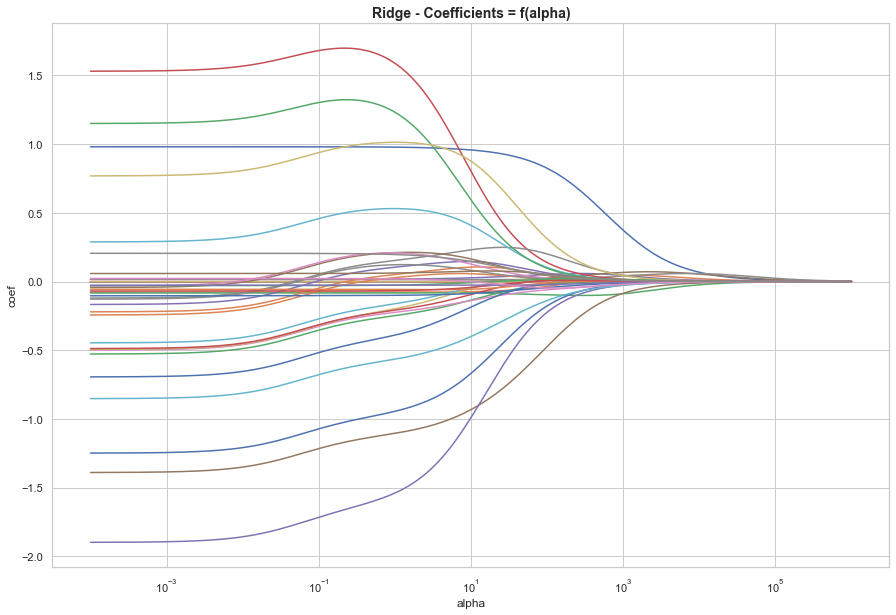

In [19]:
fig2, ax2 = plt.subplots(figsize=(15, 10))
ax2.plot(alphas4, coefs4)
ax2.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coef')
plt.title('Ridge - Coefficients = f(alpha)', fontsize=14, weight='bold')
plt.axis('tight');

## Lasso

In [20]:
from sklearn.linear_model import Lasso
n_alphas = 100
alphas5 = {'estimator5__alpha':list(np.linspace(0.0005, 0.0015, n_alphas))}

pipe5 = Pipeline([('preprocessor', preprocessor2), ('estimator5', Lasso())])


#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search5 = GridSearchCV(pipe5, param_grid=alphas5, n_jobs=1, cv=cv, scoring='r2')

grid_search5.fit(X_train, y_train)

results5=pd.DataFrame(grid_search5.cv_results_)
best_score5 = max(grid_search5.cv_results_['mean_test_score'])
fit_time5  = results5.loc[results5['mean_test_score']==best_score5, 'mean_fit_time'].values

In [21]:
print(f"Best mean test score : {best_score5} - Mean fit time : {fit_time5} - With the parameter : {grid_search5.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search5.predict(X_test))}")
result5 = [round(best_score5, 3), round(fit_time5[0], 4), round(r2_score(y_test, grid_search5.predict(X_test)), 3)]

Best mean test score : 0.7399731183658851 - Mean fit time : [0.01156182] - With the parameter : {'estimator5__alpha': 0.001005050505050505}
Test set score : 0.7364938060108592


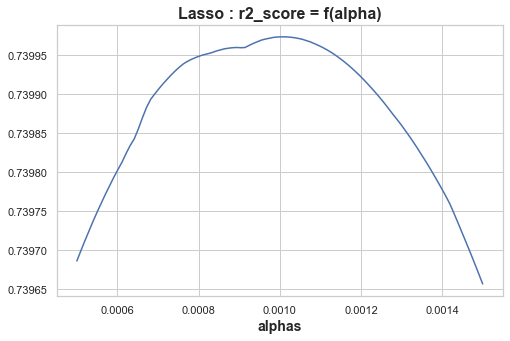

In [22]:
fig3, ax3 = plt.subplots(figsize=(8, 5))
sns.lineplot(ax=ax3, data=results5, x='param_estimator5__alpha', y='mean_test_score')
ax3.set_title('Lasso : r2_score = f(alpha)', fontsize=16, weight='bold')
ax3.tick_params(axis='y',labelsize=11)
ax3.set_ylabel('')
ax3.set_xlabel('alphas', fontsize=14, weight='bold');

In [23]:
# Tracé des coefficients fonction de alpha
estimator6 = Lasso()
pipe6 = make_pipeline(preprocessor, estimator6)
alphas6 = list(np.linspace(0.0002, 0.6, n_alphas))
coefs6 = []
for a in alphas6:
    estimator6.set_params(alpha=a)
    pipe6.fit(X_train, y_train)
    coefs6.append(estimator6.coef_)

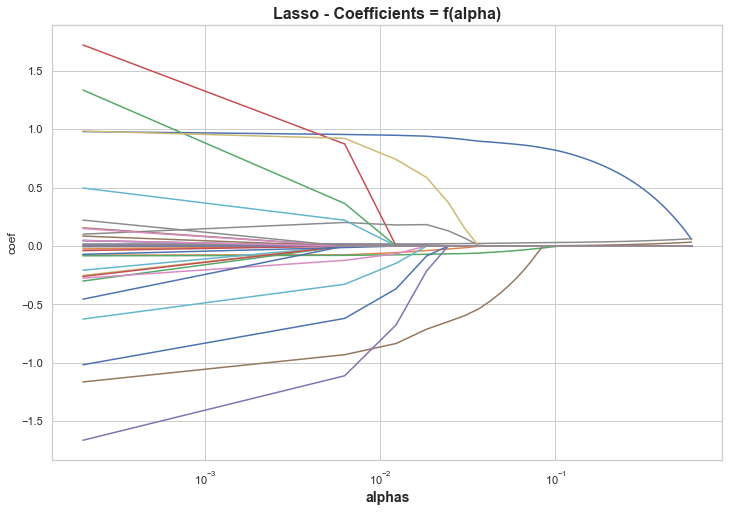

In [24]:
fig4, ax4 = plt.subplots(figsize=(12, 8))
ax4.plot(alphas6, coefs6)
ax4.set_xscale('log')

plt.ylabel('coef')
plt.title('Lasso - Coefficients = f(alpha)', fontsize=16, weight='bold')
ax4.set_xlabel('alphas', fontsize=14, weight='bold');

In [25]:
#Features non conservées par le Lasso
coefficients = grid_search5.best_estimator_.named_steps.estimator5.coef_
mask = (np.where(coefficients!=0, 1, 0))
mask = mask==1
pd.DataFrame(features2)[~mask]

,0
17,Refrigerated Warehouse
22,Social/Meeting Hall
23,Strip Mall
28,area_3
30,area_5


## RandomForestRegressor

In [26]:
import shap
from sklearn.ensemble import RandomForestRegressor
param_grid = {'estimator7__n_estimators': [500, 600],
    'estimator7__max_depth' : [14, 16]}
estimator7 = RandomForestRegressor(criterion='squared_error', random_state=0)
pipe7 = Pipeline([('preprocessor', preprocessor2), ('estimator7', estimator7)])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search7 = GridSearchCV(pipe7, param_grid=param_grid, n_jobs=1, cv=cv, scoring='r2')

grid_search7.fit(X_train, y_train);

In [27]:
results7=pd.DataFrame(grid_search7.cv_results_)
best_score7 = max(grid_search7.cv_results_['mean_test_score'])
fit_time7  = results7.loc[results7['mean_test_score']==best_score7, 'mean_fit_time'].values
print(f"Best mean test score : {best_score7} - Mean fit time : {fit_time7} - With the parameter : {grid_search7.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search7.predict(X_test))}")
result7 = [round(best_score7, 3), round(fit_time7[0], 4), round(r2_score(y_test, grid_search7.predict(X_test)), 3)]

Best mean test score : 0.716326471795514 - Mean fit time : [2.83895893] - With the parameter : {'estimator7__max_depth': 16, 'estimator7__n_estimators': 600}
Test set score : 0.7058389642110219


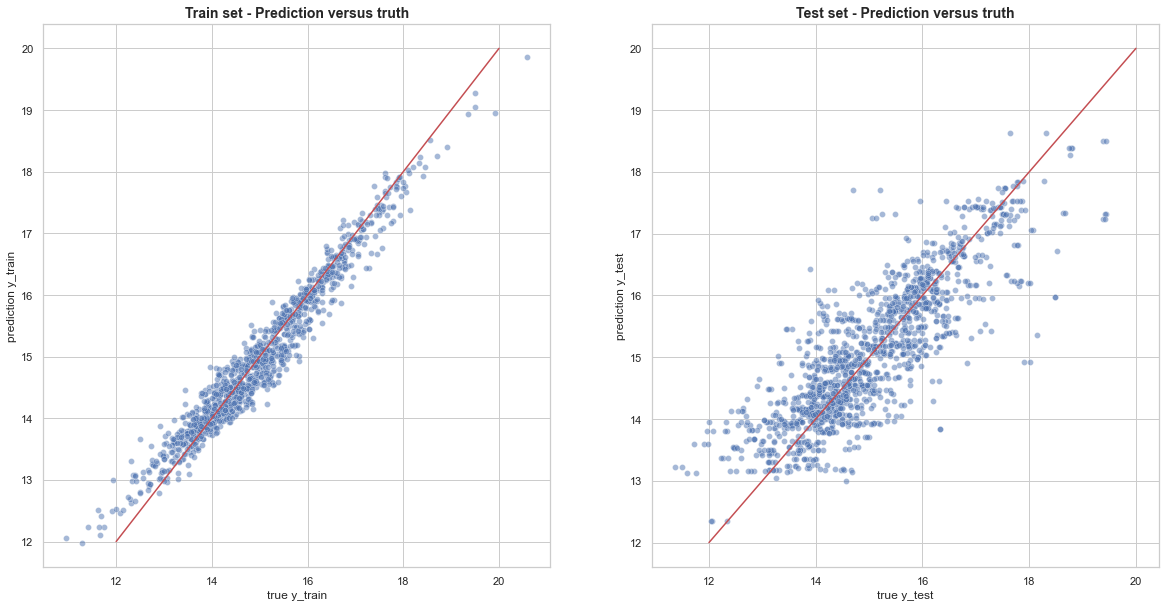

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train, y=grid_search7.predict(X_train), alpha=0.5)
sns.lineplot(ax=ax[0], x=[12, 20], y=[12, 20], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test, y=grid_search7.predict(X_test), alpha=0.5)
sns.lineplot(ax=ax[1], x=[12, 20], y=[12, 20], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');

## XGBoost

In [29]:
from xgboost import XGBRegressor
param_grid = {'estimator8__n_estimators': [75, 100, 125],
              'estimator8__max_depth' : [3, 4, 5], 
              'estimator8__eta': [0.05, 0.1, 0.15]}

estimator8 = XGBRegressor(random_state=0)
pipe8 = Pipeline([('preprocessor', preprocessor2), ('estimator8', estimator8)])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search8 = GridSearchCV(pipe8, param_grid=param_grid, n_jobs=1, cv=cv, scoring='r2')

grid_search8.fit(X_train, y_train);

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [30]:
results8=pd.DataFrame(grid_search8.cv_results_)
best_score8 = max(grid_search8.cv_results_['mean_test_score'])
fit_time8  = results8.loc[results8['mean_test_score']==best_score8, 'mean_fit_time'].values
print(f"Best mean test score : {best_score8} - Mean fit time : {fit_time8} - With the parameter : {grid_search8.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search8.predict(X_test))}")
result8 = [round(best_score8, 3), round(fit_time8[0], 4), round(r2_score(y_test, grid_search8.predict(X_test)), 3)]

Best mean test score : 0.7450859512830331 - Mean fit time : [0.18123841] - With the parameter : {'estimator8__eta': 0.15, 'estimator8__max_depth': 3, 'estimator8__n_estimators': 100}
Test set score : 0.7325872179278982


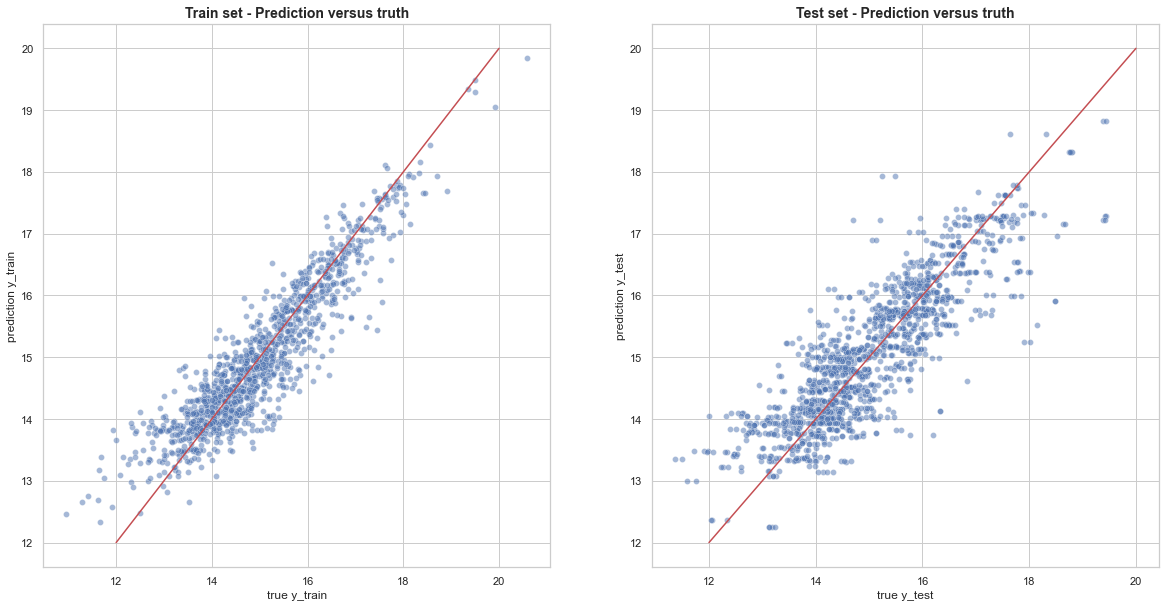

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train, y=grid_search8.predict(X_train), alpha=0.5)
sns.lineplot(ax=ax[0], x=[12, 20], y=[12, 20], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test, y=grid_search8.predict(X_test), alpha=0.5)
sns.lineplot(ax=ax[1], x=[12, 20], y=[12, 20], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');

In [32]:
fig.get_figure().savefig('SEU_XGBoost.pdf')

## Features selection
### with linear regression

In [33]:
from sklearn.feature_selection import RFECV
estimator90 = LinearRegression()
min_features_to_select = 1
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
selector90 = RFECV(estimator=estimator90,
           step=1,
           cv=cv,
           scoring="r2",
           min_features_to_select=min_features_to_select)

#Création du pipeline
pipe90 = make_pipeline(preprocessor2, selector90)

pipe90.fit(X_train, y_train)
print(pipe90.score(X_test, y_test))

0.7296106251039038


 Best mean test score : 0.7410837669495602
Optimal number of features : 17


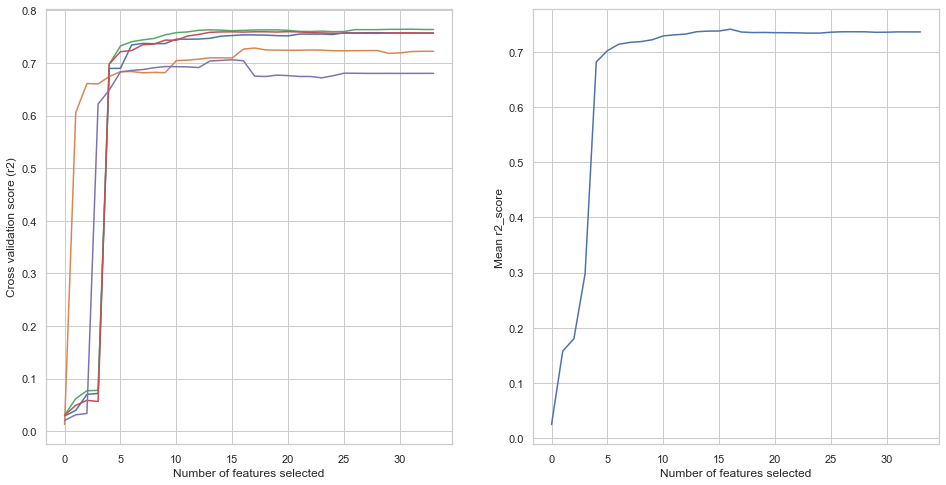

In [34]:
print(f" Best mean test score : {max(selector90.cv_results_['mean_test_score'])}")
print("Optimal number of features : %d" % selector90.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_xlabel("Number of features selected")
ax[0].set_ylabel("Cross validation score (r2)")
ax[0].plot( pd.DataFrame(selector90.cv_results_ ).iloc[:, 2:])
ax[1].set_xlabel("Number of features selected")
ax[1].set_ylabel("Mean r2_score")
ax[1].plot( pd.DataFrame(selector90.cv_results_ ).iloc[:, 0]);

### with ridge

In [35]:
estimator91 = Ridge(alpha=1.12)
min_features_to_select = 1
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
selector91 = RFECV(estimator=estimator91,
           step=1,
           cv=cv,
           scoring="r2",
           min_features_to_select=min_features_to_select)

#Création du pipeline
pipe91 = make_pipeline(preprocessor2, selector91)

pipe91.fit(X_train, y_train)
print(pipe91.score(X_test, y_test))

0.733363005415719


 Best mean test score : 0.7415903663219318
Optimal number of features : 15


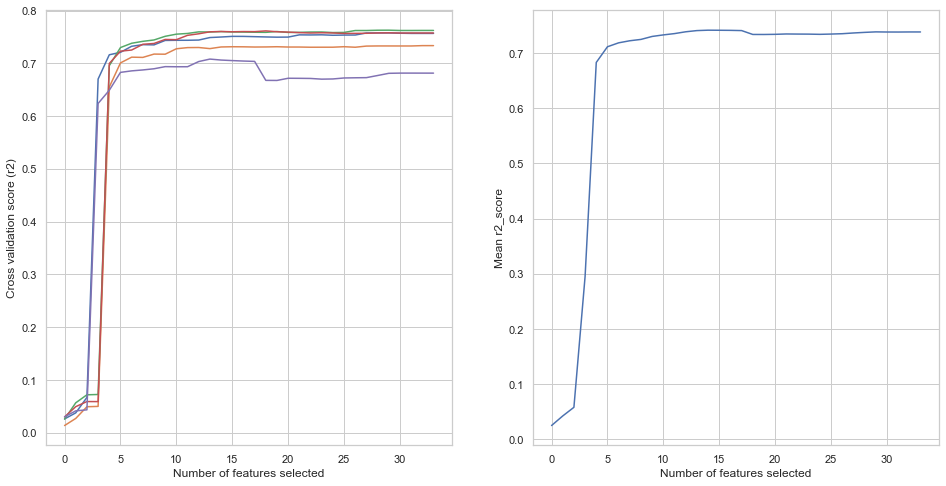

In [36]:
print(f" Best mean test score : {max(selector91.cv_results_['mean_test_score'])}")
print("Optimal number of features : %d" % selector91.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_xlabel("Number of features selected")
ax[0].set_ylabel("Cross validation score (r2)")
ax[0].plot( pd.DataFrame(selector91.cv_results_ ).iloc[:, 2:])
ax[1].set_xlabel("Number of features selected")
ax[1].set_ylabel("Mean r2_score")
ax[1].plot( pd.DataFrame(selector91.cv_results_ ).iloc[:, 0]);

### with RandomForestRegressor

In [37]:
estimator92 = XGBRegressor(n_estimators=300,
              max_depth=12)
min_features_to_select = 1
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
selector92 = RFECV(estimator=estimator92,
           step=1,
           cv=cv,
           scoring="r2",
           min_features_to_select=min_features_to_select)

#Création du pipeline
pipe92 = make_pipeline(preprocessor2, selector92)

pipe92.fit(X_train, y_train)
print(pipe92.score(X_test, y_test))
Xtrain_reduct92 = pipe92.transform(X_train)
Xtest_reduct92 = pipe92.transform(X_test)

0.6862274342230372


 Best mean test score : 0.7056123741070606
Optimal number of features : 33


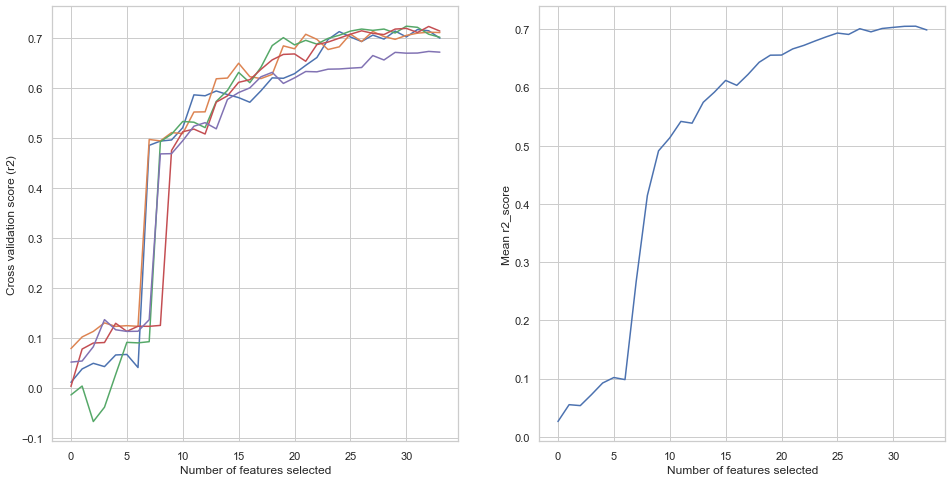

In [38]:
print(f" Best mean test score : {max(selector92.cv_results_['mean_test_score'])}")
print("Optimal number of features : %d" % selector92.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_xlabel("Number of features selected")
ax[0].set_ylabel("Cross validation score (r2)")
ax[0].plot( pd.DataFrame(selector92.cv_results_ ).iloc[:, 2:])
ax[1].set_xlabel("Number of features selected")
ax[1].set_ylabel("Mean r2_score")
ax[1].plot( pd.DataFrame(selector92.cv_results_ ).iloc[:, 0]);

### with XGBoost

In [39]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
estimator93 = XGBRegressor(n_estimators=75,
              max_depth=3, 
              eta=0.15, 
              colsample_bytree=0.5)
min_features_to_select = 1
selector93 = RFECV(estimator=estimator93,
           step=1,
           cv=cv,
           scoring="r2",
           min_features_to_select=min_features_to_select)

#Création du pipeline
pipe93 = make_pipeline(preprocessor, selector93)

pipe93.fit(X_train, y_train)
print(pipe93.score(X_train, y_train))
print(pipe93.score(X_test, y_test))

0.8289688639894869
0.7395852480709035


 Best mean test score : 0.7425799844945453
Optimal number of features : 34


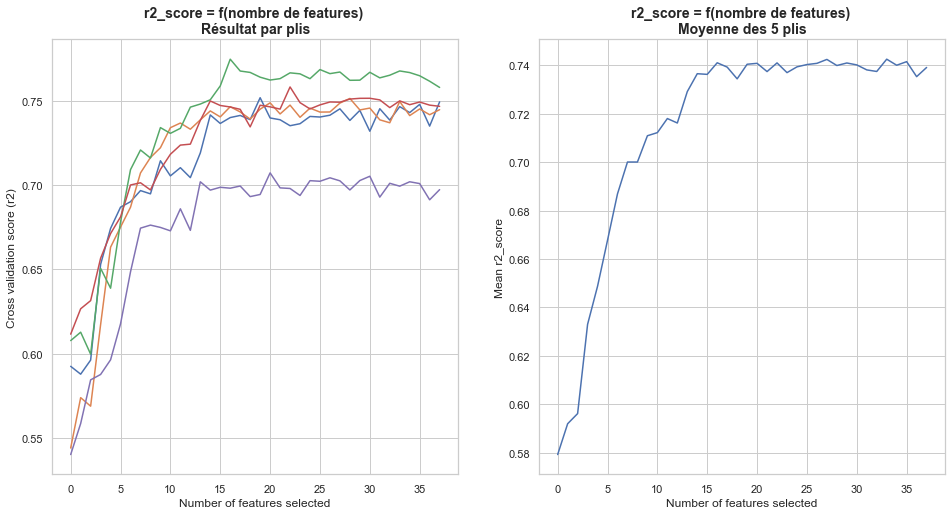

In [40]:
print(f" Best mean test score : {max(selector93.cv_results_['mean_test_score'])}")
print("Optimal number of features : %d" % selector93.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_xlabel("Number of features selected")
ax[0].set_ylabel("Cross validation score (r2)")
ax[0].plot( pd.DataFrame(selector93.cv_results_ ).iloc[:, 2:])
ax[0].set_title('r2_score = f(nombre de features) \nRésultat par plis', fontsize=14, weight='bold')
ax[1].set_xlabel("Number of features selected")
ax[1].set_ylabel("Mean r2_score")
ax[1].plot( pd.DataFrame(selector93.cv_results_ ).iloc[:, 0])
ax[1].set_title('r2_score = f(nombre de features) \nMoyenne des 5 plis', fontsize=14, weight='bold');

In [41]:
fig.get_figure().savefig('SEU_RFECV.pdf')

## XGBoost with a feature selection

### Features selection

In [42]:
#On sélectionne les 16 features les plus importantes avec RFE 
from sklearn.feature_selection import RFE
estimator9 = XGBRegressor(n_estimators=75,
              max_depth=3, 
              eta=0.15, 
              colsample_bytree=0.5, random_state=0)
n_features_to_select = 16
selector9 = RFE(estimator=estimator9,
           step=1,
           n_features_to_select=n_features_to_select)

#Création du pipeline
pipe9 = make_pipeline(preprocessor2, selector9)

pipe9.fit(X_train, y_train)
print(pipe9.score(X_test, y_test))

0.7415781520402577


In [43]:
X_train.shape

(1208, 34)

In [44]:
features_rank = pd.DataFrame(selector9.ranking_).rename(columns={0: 'rank'})
features_rank['features'] = features2

In [45]:
features_reduct = list(features_rank.loc[features_rank['rank']==1, 'features'])
pd.DataFrame(features_reduct)

,0
0,PropertyGFATotal
1,building_age
2,NumberofBuildings
3,NumberofFloors
4,Distribution Center
5,Laboratory
6,Non-Refrigerated Warehouse
7,Office
8,Other
9,Other - Recreation


In [46]:
Xtrain_reduct = pipe9.transform(X_train)
Xtest_reduct = pipe9.transform(X_test)

In [47]:
Xtrain_reduct = pd.DataFrame(columns=features_reduct, data=Xtrain_reduct)
Xtest_reduct = pd.DataFrame(columns=features_reduct, data=Xtest_reduct)
Xtrain_reduct

,PropertyGFATotal,building_age,NumberofBuildings,NumberofFloors,Distribution Center,Laboratory,Non-Refrigerated Warehouse,Office,Other,Other - Recreation,Restaurant,Self-Storage Facility,Senior Care Community,Supermarket/Grocery Store,Worship Facility,area_8
0,1.107611,-0.337198,-0.066349,1.532530,0.0,0.0,0.000000,0.843332,0.001109,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,-0.187568,0.183330,-0.066349,-0.499800,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.338581,-1.163972,-0.066349,-0.030801,0.0,0.0,0.000000,0.976701,0.000000,0.0,0.0,0.0,0.0,0.0,0.023299,0.0
3,1.010919,1.255069,-0.066349,-0.187134,0.0,0.0,0.000000,0.000000,0.624337,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,-0.437353,1.408151,-0.066349,0.281865,0.0,0.0,0.087437,0.513202,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,-0.342216,-0.122917,-0.066349,-0.343467,0.0,0.0,0.000000,0.020290,0.000000,0.0,0.0,0.0,0.0,0.0,0.958314,0.0
1204,-0.968817,0.030249,-0.066349,-0.499800,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1205,-1.064615,0.305812,-0.066349,-0.343467,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0
1206,-0.729501,1.010105,-0.066349,-0.030801,0.0,0.0,0.000000,0.718878,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### XGBoost

In [48]:
param_grid99 = {'estimator99__n_estimators': [75, 80, 85],
              'estimator99__max_depth' : [3, 4, 5], 
              'estimator99__eta': [0.05, 0.1, 0.15], 
              'estimator99__colsample_bytree': [0.55, 0.6, 0.65]}


estimator99 = XGBRegressor(random_state=0)
pipe99 = Pipeline([('estimator99', estimator99)])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search99 = GridSearchCV(pipe99, param_grid=param_grid99, n_jobs=1, cv=cv, scoring='r2')

grid_search99.fit(Xtrain_reduct.values, y_train);
results99=pd.DataFrame(grid_search99.cv_results_)
best_score99 = max(results99['mean_test_score'])
fit_time99  = results99.loc[results99['mean_test_score']==best_score99, 'mean_fit_time'].values

In [49]:
print(f"Best mean test score : {best_score99} - Mean fit time : {fit_time99} - With the parameter : {grid_search99.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search99.predict(Xtest_reduct))}")
result99 = [round(best_score99, 3), round(fit_time99[0], 4), round(r2_score(y_test, grid_search99.predict(Xtest_reduct)), 3)]

Best mean test score : 0.7446484404993319 - Mean fit time : [0.08311286] - With the parameter : {'estimator99__colsample_bytree': 0.6, 'estimator99__eta': 0.1, 'estimator99__max_depth': 4, 'estimator99__n_estimators': 85}
Test set score : 0.7354148051452609


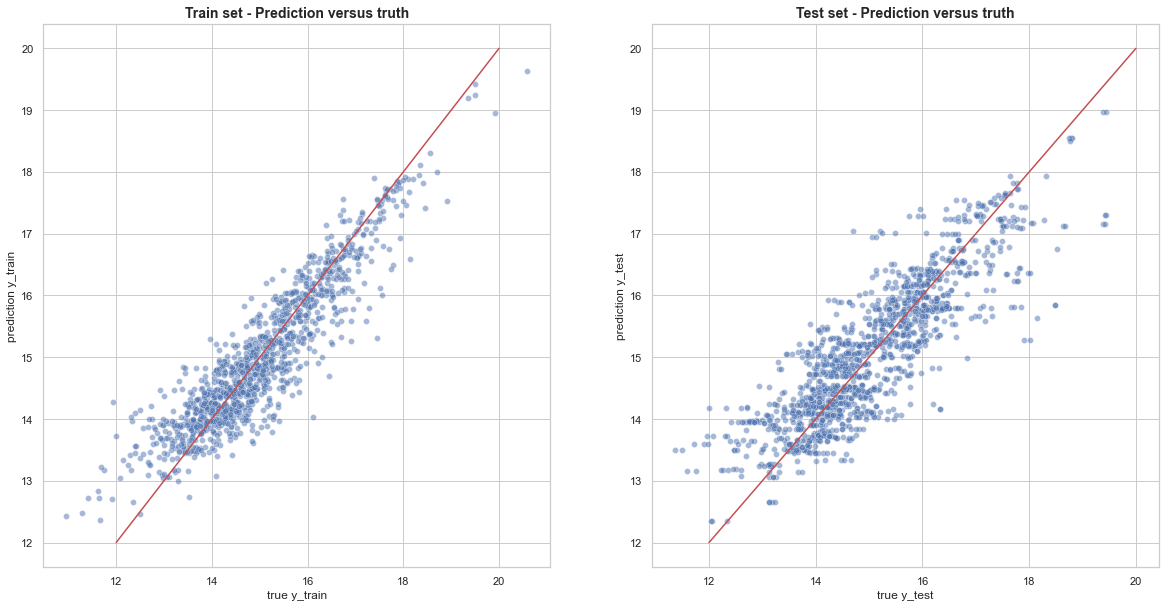

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train, y=grid_search99.predict(Xtrain_reduct), alpha=0.5)
sns.lineplot(ax=ax[0], x=[12, 20], y=[12, 20], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test, y=grid_search99.predict(Xtest_reduct), alpha=0.5)
sns.lineplot(ax=ax[1], x=[12, 20], y=[12, 20], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');

In [51]:
fig.get_figure().savefig('SEU_RFE_XGBoost.pdf')

# Résultats
## Tests par année

In [52]:
models = {'Regression linéaire': pipe2, 'Regression ridge': grid_search3, 'Lasso': grid_search5, 'Random Forest': grid_search7, 'XGBoost': grid_search8}
datas = {'2016':(X_test16, y_test16), '2017':(X_test17, y_test17), '2019':(X_test19, y_test19), '2020':(X_test20, y_test20)}

In [53]:
recap_result = pd.DataFrame({'Linear regression': [pipe2.score(data[0], data[1]) for date, data in datas.items()], 
                             'Regression ridge':[grid_search3.score(data[0], data[1]) for date, data in datas.items()], 
                             'Lasso':[grid_search5.score(data[0], data[1]) for date, data in datas.items()], 
                             'Random Forest': [grid_search7.score(data[0], data[1]) for date, data in datas.items()],
                             'XGBoost': [grid_search8.score(data[0], data[1]) for date, data in datas.items()]}, 
                            index=[2016, 2017, 2019, 2020])
recap_result   

,Linear regression,Regression ridge,Lasso,Random Forest,XGBoost
2016,0.755160,0.756845,0.755533,0.725628,0.742505
2017,0.735238,0.736242,0.737523,0.710825,0.734526
2019,0.740464,0.740664,0.742028,0.702270,0.724119
2020,0.711407,0.711209,0.712686,0.686295,0.727544


## Synthèse résultats par modèle

In [54]:
index = ['Dummy regression', 'Linear regression', 'Ridge regression', 'Lasso', 'RandomForestRegressor', 'XGBoost', 'Recursive Feature Elimination and XGBoost']
columns = ['Best mean r2 score', 'Mean fit time', 'Score for test set']
results = pd.DataFrame(index=index, columns=columns, data=np.vstack((result1, result2, result3, result5, result7, result8, result99)))
results

,Best mean r2 score,Mean fit time,Score for test set
Dummy regression,0.000,0.0213,-0.002
Linear regression,0.736,0.0149,0.735
Ridge regression,0.739,0.0108,0.736
Lasso,0.740,0.0116,0.736
RandomForestRegressor,0.716,2.8390,0.706
XGBoost,0.745,0.1812,0.733
Recursive Feature Elimination and XGBoost,0.745,0.0831,0.735


In [55]:
#Choix de l'algorithme : XBBoost avec une réduction du nombre de features préalable

# Avec la feature star score

In [56]:
train_star = pd.read_csv('train_star.csv').drop('Unnamed: 0', axis=1)
test_star = pd.read_csv('test_star.csv').drop('Unnamed: 0', axis=1)

In [57]:
cat_list = list(train_star.loc[:, 'College/University':'area_8'].columns)
X_train_star = train_star.iloc[:, 1:]
X_test_star = test_star.iloc[:, 1:]
y_train_star = train_star['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values
y_test_star = test_star['SiteEnergyUse(kBtu)'].apply(lambda x: np.log(1+x)).values


In [58]:
preprocessor3 = ColumnTransformer([('numerical', numeric_preprocessor, ['PropertyGFATotal', 'PropertyGFAParking']), 
                                  ('discret', discret_preprocessor2, ['ENERGYSTARScore', 'building_age', 'NumberofBuildings', 'NumberofFloors']), 
                                  ('categorical', cat_preprocessor, cat_list)])

In [59]:
features_star = []
for i in range(len(preprocessor3.transformers)):
    features_star += preprocessor3.transformers[i][2]  

## Modèle RFE+ XGBoost avec Star
### Features selection

In [60]:
min_features_to_select = 1
estimator100 = XGBRegressor(n_estimators=75,
              max_depth=3, 
              eta=0.15, 
              colsample_bytree=0.5)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
selector100 = RFECV(estimator=estimator93,
           step=1,
           cv=cv,
           scoring="r2",
           min_features_to_select=min_features_to_select)
#Création du pipeline
pipe100 = make_pipeline(preprocessor3, selector100)

pipe100.fit(X_train_star, y_train_star)
print(pipe100.score(X_test_star, y_test_star))
print(pipe100.score(X_train_star, y_train_star))

0.8505685205354063
0.9334019160751329


Best mean test score : 0.8530236791018675
Optimal number of features : 26


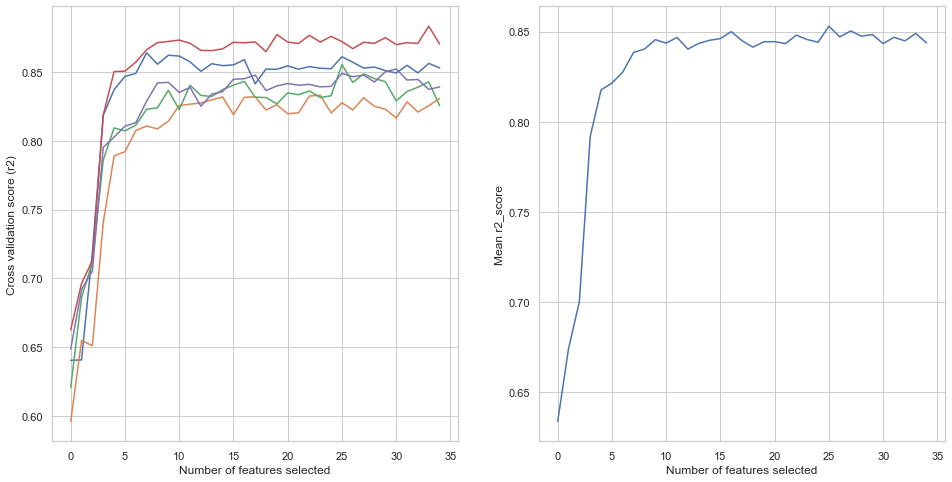

In [61]:
print(f"Best mean test score : {max(selector100.cv_results_['mean_test_score'])}")
print("Optimal number of features : %d" % selector100.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_xlabel("Number of features selected")
ax[0].set_ylabel("Cross validation score (r2)")
ax[0].plot( pd.DataFrame(selector100.cv_results_ ).iloc[:, 2:])
ax[1].set_xlabel("Number of features selected")
ax[1].set_ylabel("Mean r2_score")
ax[1].plot( pd.DataFrame(selector100.cv_results_ ).iloc[:, 0]);

In [62]:
#Sélection des 9 features les plus importantes avec RFE 
from sklearn.feature_selection import RFE
estimator101 = XGBRegressor(n_estimators=75,
                            max_depth=3, 
                            eta=0.15, 
                            colsample_bytree=0.5,
                            random_state=0)
n_features_to_select = 9
selector101 = RFE(estimator=estimator101,
           step=1,
           n_features_to_select=n_features_to_select)

#Création du pipeline
pipe101 = make_pipeline(preprocessor3, selector101)

pipe101.fit(X_train_star, y_train_star)
print(pipe101.score(X_test_star, y_test_star))

0.8327920346356134


In [63]:
features_rank_star = pd.DataFrame(selector101.ranking_).rename(columns={0: 'rank'})
features_rank_star['features'] = features_star
features_rank_star_reduct = list(features_rank_star.loc[features_rank_star['rank']==1, 'features'])
pd.DataFrame(features_rank_star_reduct)

,0
0,PropertyGFATotal
1,ENERGYSTARScore
2,NumberofBuildings
3,NumberofFloors
4,Distribution Center
5,Non-Refrigerated Warehouse
6,Other
7,Supermarket/Grocery Store
8,Worship Facility


In [64]:
X_train_star_reduct = pipe101.transform(X_train_star)
X_test_star_reduct = pipe101.transform(X_test_star)

X_train_star_reduct = pd.DataFrame(columns=features_rank_star_reduct, data=X_train_star_reduct)
X_test_star_reduct = pd.DataFrame(columns=features_rank_star_reduct, data=X_test_star_reduct)

In [65]:
X_train_star_reduct

,PropertyGFATotal,ENERGYSTARScore,NumberofBuildings,NumberofFloors,Distribution Center,Non-Refrigerated Warehouse,Other,Supermarket/Grocery Store,Worship Facility
0,0.990383,1.114235,-0.093351,1.167882,0.0,0.000000,0.001109,0.0,0.000000
1,-0.284533,-0.885670,-0.093351,-0.525631,0.0,1.000000,0.000000,0.0,0.000000
2,0.233384,0.321170,-0.093351,-0.134820,0.0,0.000000,0.000000,0.0,0.023299
3,-0.517426,-0.885670,-0.093351,-0.525631,1.0,0.000000,0.000000,0.0,0.000000
4,-0.572607,1.252160,-0.093351,-0.134820,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
768,0.127764,-0.851189,-0.093351,-0.395361,0.0,0.536373,0.000000,0.0,0.000000
769,-0.133494,-1.609773,-0.093351,-0.265091,0.0,0.000000,0.000000,0.0,0.000000
770,2.536797,-1.816660,9.658048,0.646801,0.0,0.000000,1.000000,0.0,0.000000
771,-1.147859,1.148717,-0.093351,-0.395361,0.0,0.000000,0.000000,0.0,1.000000


### XGBoost

In [66]:
param_grid10 = {'n_estimators': [100, 150, 200],
              'max_depth' : [1, 2, 3], 
              'eta': [0.2, 0.25, 0.3], 
              'colsample_bytree': [0.85, 0.9, 0.95]}

In [67]:
#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search10 = GridSearchCV(estimator=XGBRegressor(random_state=0), param_grid=param_grid10, n_jobs=1, cv=cv, scoring='r2')
grid_search10.fit((X_train_star_reduct.values), y_train_star)
results10=pd.DataFrame(grid_search10.cv_results_)
best_score10 = max(results10['mean_test_score'])

fit_time10  = results10.loc[results10['mean_test_score']==best_score10, 'mean_fit_time'].values

In [68]:
print(f"Best mean test score : {best_score10} - Mean fit time : {fit_time10} - With the parameter : {grid_search10.best_params_}" )
print(f"Test set score : {r2_score(y_test_star, grid_search10.predict(X_test_star_reduct))}")
result10 = [round(best_score10, 3), round(fit_time10[0], 4), round(r2_score(y_test_star, grid_search10.predict(X_test_star_reduct)), 3)]

Best mean test score : 0.8583638882135383 - Mean fit time : [0.08419728] - With the parameter : {'colsample_bytree': 0.85, 'eta': 0.2, 'max_depth': 1, 'n_estimators': 200}
Test set score : 0.8331816399540525


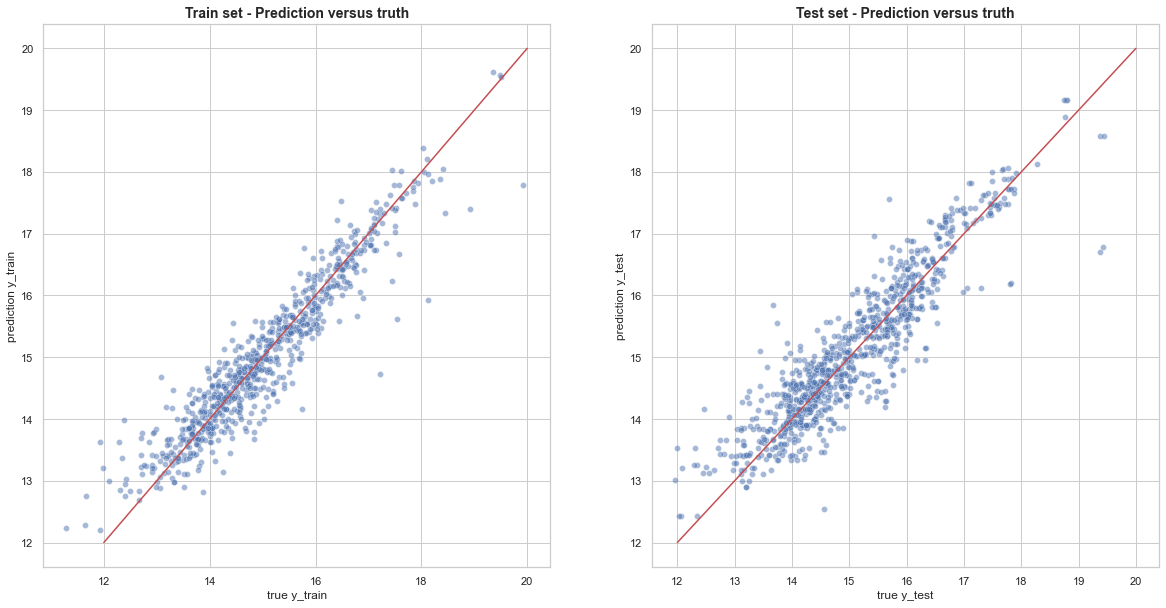

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train_star, y=grid_search10.predict(X_train_star_reduct), alpha=0.5)
sns.lineplot(ax=ax[0], x=[12, 20], y=[12, 20], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test_star, y=grid_search10.predict(X_test_star_reduct), alpha=0.5)
sns.lineplot(ax=ax[1], x=[12, 20], y=[12, 20], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');

## Ridge avec Star score

In [70]:
estimator11 = Ridge()
pipe11 = make_pipeline(preprocessor3, estimator11)
n_alphas = 200
alphas = {'ridge__alpha':list(np.linspace(3, 4, n_alphas))}


#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search11 = GridSearchCV(pipe11, param_grid=alphas, n_jobs=1, cv=cv, scoring='r2')
grid_search11.fit(X_train_star, y_train_star)
results11=pd.DataFrame(grid_search11.cv_results_)
best_score11 = max(results11['mean_test_score'])

fit_time11  = results11.loc[results11['mean_test_score']==best_score11, 'mean_fit_time'].values;


In [71]:
print(f"Best mean test score : {best_score11} - Mean fit time : {fit_time11} - With the parameter : {grid_search11.best_params_}" )
print(f"Test set score : {r2_score(y_test_star, grid_search11.predict(X_test_star))}")
result11 = [round(best_score11, 3), round(fit_time3[0], 4), round(r2_score(y_test_star, grid_search11.predict(X_test_star)), 3)]


Best mean test score : 0.8687293936276161 - Mean fit time : [0.01150422] - With the parameter : {'ridge__alpha': 3.2864321608040203}
Test set score : 0.8450777689545617


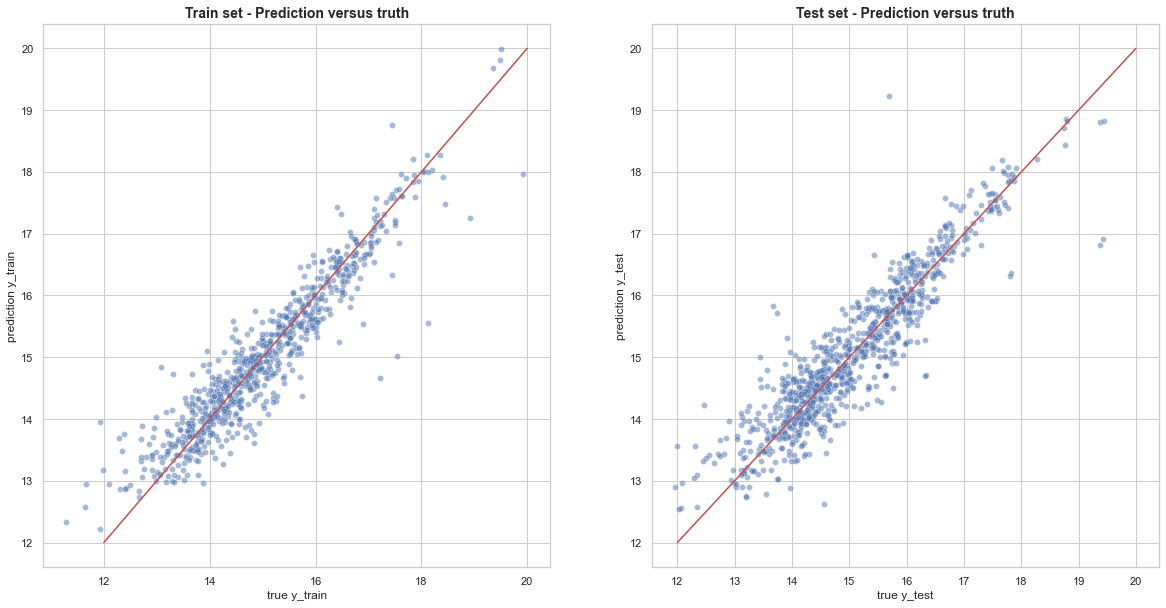

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train_star, y=grid_search11.predict(X_train_star), alpha=0.5)
sns.lineplot(ax=ax[0], x=[12, 20], y=[12, 20], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test_star, y=grid_search11.predict(X_test_star), alpha=0.5)
sns.lineplot(ax=ax[1], x=[12, 20], y=[12, 20], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');           

In [73]:
fig.get_figure().savefig('SEU_ridge_star.pdf')

# Résultats Consommation énergétique

In [74]:
index = ['Dummy regression', 
         'Linear regression', 
         'Ridge regression', 
         'Lasso', 
         'RandomForestRegressor', 
         'XGBoost', 
         'Recursive Feature Elimination and XGBoost', 
         'RFE + XGBoost with star score', 
         'Ridge Regression with star score']
columns = ['Best mean r2 score', 'Mean fit time', 'Score for test set']
results = pd.DataFrame(index=index, columns=columns, data=np.vstack((result1, result2, result3, result5, result7, result8, result99, result10, result11)))
results

,Best mean r2 score,Mean fit time,Score for test set
Dummy regression,0.000,0.0213,-0.002
Linear regression,0.736,0.0149,0.735
Ridge regression,0.739,0.0108,0.736
Lasso,0.740,0.0116,0.736
RandomForestRegressor,0.716,2.8390,0.706
XGBoost,0.745,0.1812,0.733
Recursive Feature Elimination and XGBoost,0.745,0.0831,0.735
RFE + XGBoost with star score,0.858,0.0842,0.833
Ridge Regression with star score,0.869,0.0108,0.845


In [75]:
# L'apport de la feature supplémentaire energie star score est très nette (score et temps de calcul).

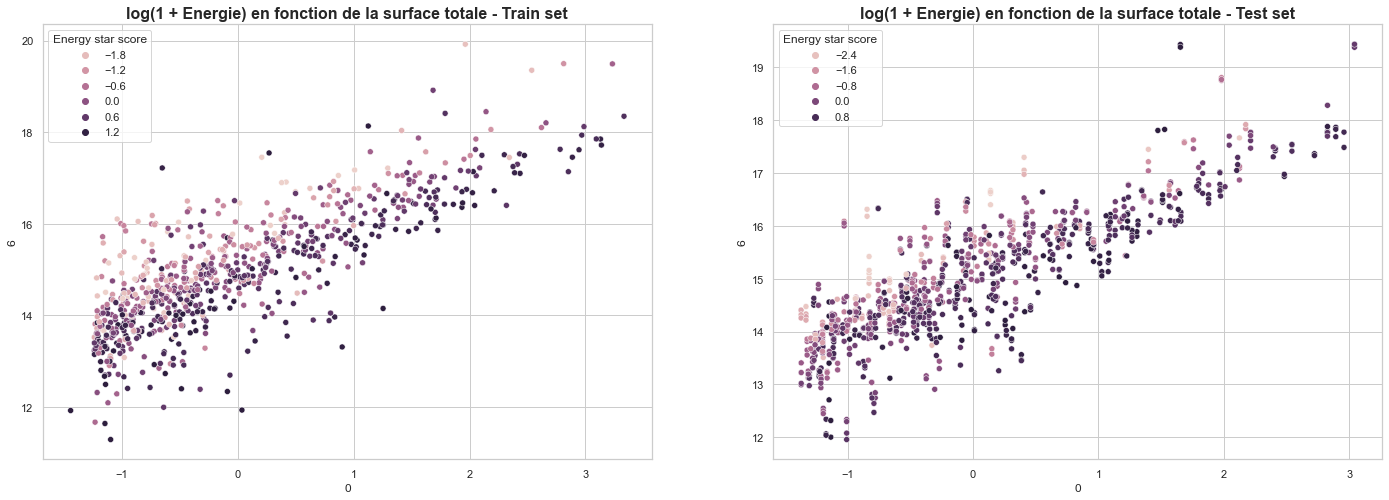

In [76]:
X_train_transformed = pd.concat([pd.DataFrame(preprocessor3.fit_transform(X_train_star)).iloc[:, 0:6], pd.DataFrame(y_train_star)], axis=1, ignore_index=True)
X_test_transformed = pd.concat([pd.DataFrame(preprocessor3.fit_transform(X_test_star)).iloc[:, 0:6], pd.DataFrame(y_test_star)], axis=1, ignore_index=True)
fig0, ax0 = plt.subplots(1, 2, figsize=(24, 8))
sns.scatterplot(ax=ax0[0], x=X_train_transformed.iloc[:, 0], y=X_train_transformed.iloc[:, 6], hue=X_train_transformed.iloc[:, 2])
ax0[0].set_title('log(1 + Energie) en fonction de la surface totale - Train set', fontsize=16, weight='bold')
ax0[0].legend(title='Energy star score')
sns.scatterplot(ax=ax0[1], x=X_test_transformed.iloc[:, 0], y=X_test_transformed.iloc[:, 6], hue=X_test_transformed.iloc[:, 2])
ax0[1].set_title('log(1 + Energie) en fonction de la surface totale - Test set', fontsize=16, weight='bold')
ax0[1].legend(title='Energy star score');

In [77]:
fig0.get_figure().savefig('SEI_surface.pdf')

# Feature importance

In [78]:
import shap
X_train_transformed = pd.DataFrame(preprocessor2.fit_transform(X_train), columns=features2)
X_test_transformed = pd.DataFrame(preprocessor2.fit_transform(X_test), columns=features2)

## Linear regression
### Coef

In [79]:
coef = pd.DataFrame(estimator2.coef_).rename(columns={0: 'coef' })
coef['features'] = features2
coef ['valeur_absolue_coef'] = abs(coef['coef'])
coef.sort_values('valeur_absolue_coef', ascending=False).iloc[:10, :]

,coef,features,valeur_absolue_coef
20,-1.909537,Self-Storage Facility,1.909537
9,1.525057,Laboratory,1.525057
11,-1.406738,Non-Refrigerated Warehouse,1.406738
6,-1.264651,Distribution Center,1.264651
18,1.119747,Restaurant,1.119747
0,1.005115,PropertyGFATotal,1.005115
25,-0.870722,Worship Facility,0.870722
24,0.744296,Supermarket/Grocery Store,0.744296
16,-0.691621,Parking,0.691621
8,-0.551496,K-12 School,0.551496


### Valeur de shapley 

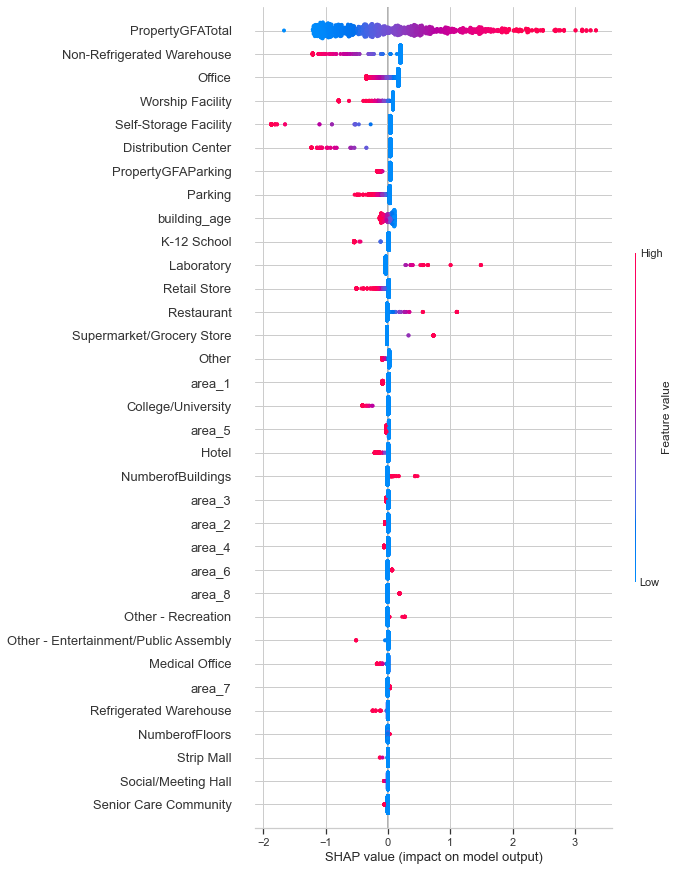

In [80]:
lin_reg_explainer1 = shap.LinearExplainer(estimator2, X_train_transformed)
shap.summary_plot(lin_reg_explainer1.shap_values(X_test_transformed),
                  features = X_test_transformed,max_display=36, show=False)
plt.gcf().axes[-1].set_aspect(200)
plt.gcf().axes[-1].set_box_aspect(500)

### Valeur de shapley - par bâtiment

College/University                       0.000000
Distribution Center                      0.796432
Hotel                                    0.000000
K-12 School                              0.000000
Laboratory                               0.000000
Medical Office                           0.000000
Non-Refrigerated Warehouse               0.000000
Office                                   0.203568
Other                                    0.000000
Other - Entertainment/Public Assembly    0.000000
Other - Recreation                       0.000000
Parking                                  0.000000
Refrigerated Warehouse                   0.000000
Restaurant                               0.000000
Retail Store                             0.000000
Self-Storage Facility                    0.000000
Senior Care Community                    0.000000
Social/Meeting Hall                      0.000000
Strip Mall                               0.000000
Supermarket/Grocery Store                0.000000


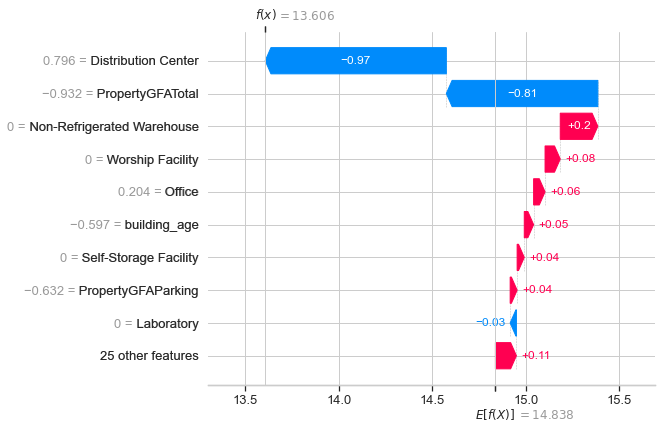

None


In [81]:
i = random.randint(0, len(X_test_transformed))
shap_values = lin_reg_explainer1(X_test_transformed[i:i+1])
shap_values.feature_names = features2
print(X_test_transformed.iloc[i, 5:26])
print(shap.waterfall_plot(shap_values[0], max_display=10))

## XGBoost
### Feature importances

In [82]:
estimator8.fit(X_train_transformed.values, y_train)
Features_importance_estimator8 = pd.DataFrame(estimator8.feature_importances_)
Features_importance_estimator8['Features'] = features2
Features_importance_estimator8 = Features_importance_estimator8.rename(columns={0:'rank'})
Features_importance_estimator8.sort_values('rank', ascending=False).iloc[:10, :]

,rank,Features
24,0.140622,Supermarket/Grocery Store
20,0.104007,Self-Storage Facility
0,0.099259,PropertyGFATotal
9,0.067300,Laboratory
3,0.066513,NumberofBuildings
11,0.052286,Non-Refrigerated Warehouse
18,0.038657,Restaurant
6,0.034725,Distribution Center
15,0.025228,Other - Recreation
13,0.024157,Other


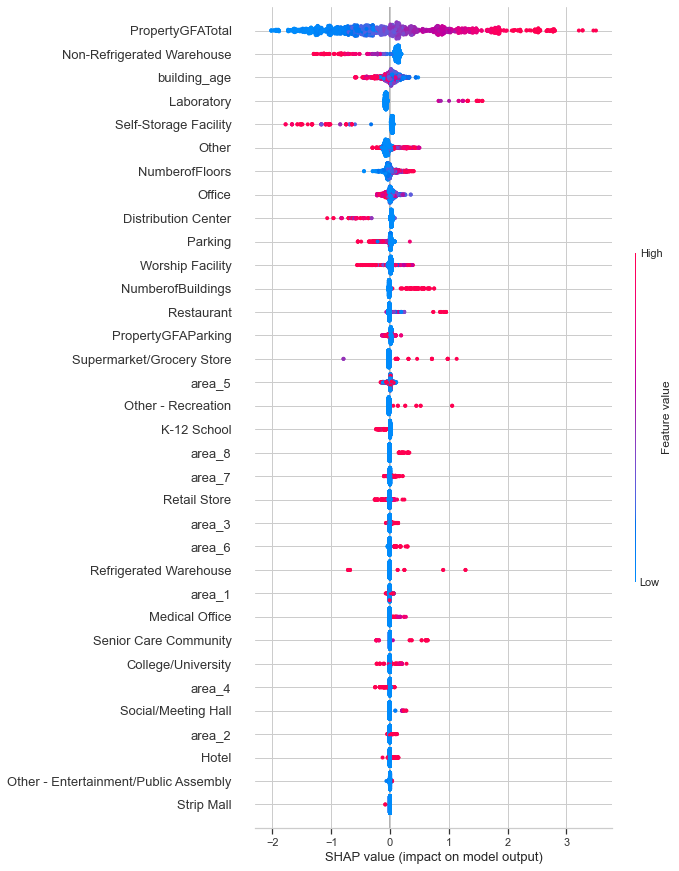

In [83]:
tree_explainer1 = shap.TreeExplainer(estimator8, X_train_transformed)
shap.summary_plot(tree_explainer1.shap_values(X_test_transformed),
                  features = X_test_transformed,
                  feature_names=features2, max_display=34, show=False)
plt.gcf().axes[-1].set_aspect(200)
plt.gcf().axes[-1].set_box_aspect(500)

### Valeur de Shapley par batiment

College/University                       0.0
Distribution Center                      0.0
Hotel                                    0.0
K-12 School                              0.0
Laboratory                               0.0
Medical Office                           0.0
Non-Refrigerated Warehouse               0.0
Office                                   1.0
Other                                    0.0
Other - Entertainment/Public Assembly    0.0
Other - Recreation                       0.0
Parking                                  0.0
Refrigerated Warehouse                   0.0
Restaurant                               0.0
Retail Store                             0.0
Self-Storage Facility                    0.0
Senior Care Community                    0.0
Social/Meeting Hall                      0.0
Strip Mall                               0.0
Supermarket/Grocery Store                0.0
Worship Facility                         0.0
Name: 589, dtype: float64


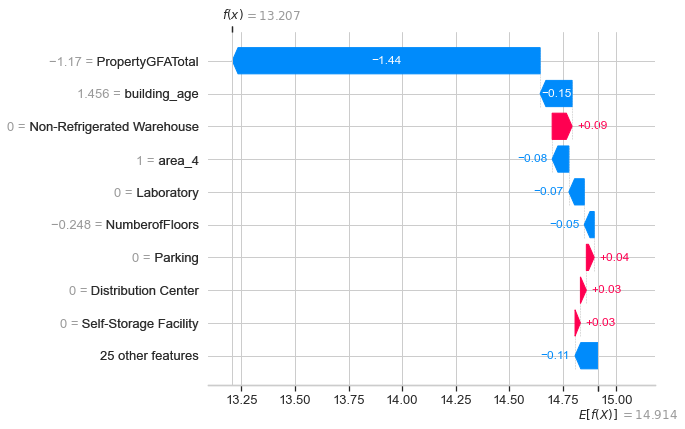

None


In [84]:
i = random.randint(0, len(X_test_transformed))
shap_values = tree_explainer1(X_test_transformed[i:i+1])
shap_values.feature_names = features2
print(X_test_transformed.iloc[i, 5:26])
print(shap.waterfall_plot(shap_values[0], max_display=10))

## RFE + XGBoost
### Valeur de Shapley 

In [85]:
grid_search10.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85,
             enable_categorical=False, eta=0.2, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [86]:
X_train_star_reduct

,PropertyGFATotal,ENERGYSTARScore,NumberofBuildings,NumberofFloors,Distribution Center,Non-Refrigerated Warehouse,Other,Supermarket/Grocery Store,Worship Facility
0,0.990383,1.114235,-0.093351,1.167882,0.0,0.000000,0.001109,0.0,0.000000
1,-0.284533,-0.885670,-0.093351,-0.525631,0.0,1.000000,0.000000,0.0,0.000000
2,0.233384,0.321170,-0.093351,-0.134820,0.0,0.000000,0.000000,0.0,0.023299
3,-0.517426,-0.885670,-0.093351,-0.525631,1.0,0.000000,0.000000,0.0,0.000000
4,-0.572607,1.252160,-0.093351,-0.134820,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
768,0.127764,-0.851189,-0.093351,-0.395361,0.0,0.536373,0.000000,0.0,0.000000
769,-0.133494,-1.609773,-0.093351,-0.265091,0.0,0.000000,0.000000,0.0,0.000000
770,2.536797,-1.816660,9.658048,0.646801,0.0,0.000000,1.000000,0.0,0.000000
771,-1.147859,1.148717,-0.093351,-0.395361,0.0,0.000000,0.000000,0.0,1.000000


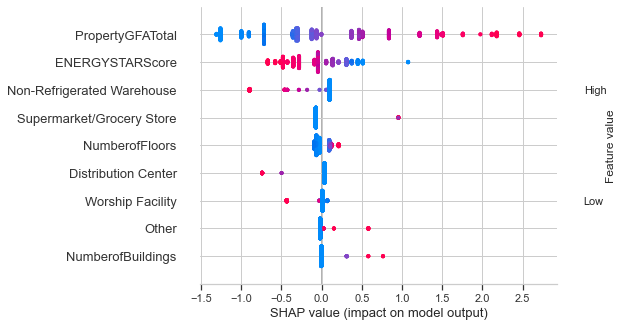

In [87]:
tree_explainer2 = shap.TreeExplainer(grid_search10.best_estimator_, X_train_star_reduct)
shap.summary_plot(tree_explainer2.shap_values(X_test_star_reduct),
                  features = X_test_star_reduct,
                  feature_names=features_rank_star_reduct, max_display=34, show=False)
plt.gcf().axes[-1].set_aspect(200)
plt.gcf().axes[-1].set_box_aspect(500)

### Valeur de Shapley par batiment

PropertyGFATotal             -1.020809
ENERGYSTARScore               1.045273
NumberofBuildings            -0.093351
NumberofFloors               -0.265091
Distribution Center           0.000000
Non-Refrigerated Warehouse    1.000000
Other                         0.000000
Supermarket/Grocery Store     0.000000
Worship Facility              0.000000
Name: 562, dtype: float64


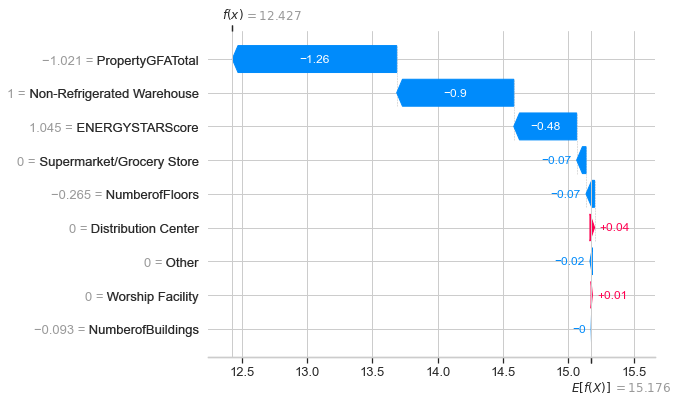

None


In [88]:
i = random.randint(0, len(X_test_star_reduct))
shap_values = tree_explainer2(X_test_star_reduct[i:i+1])
shap_values.feature_names = features_rank_star_reduct
print(X_test_star_reduct.iloc[i])
print(shap.waterfall_plot(shap_values[0], max_display=len(features_rank_star_reduct)))

## Ridge avec star
### Coef

In [89]:
coef = pd.DataFrame(grid_search11.best_estimator_[1].coef_).rename(columns={0: 'coef' })
coef['features'] = features_star
coef ['valeur_absolue_coef'] = abs(coef['coef'])
coef.sort_values('valeur_absolue_coef', ascending=False).iloc[:10, :]

,coef,features,valeur_absolue_coef
0,1.081515,PropertyGFATotal,1.081515
12,-1.032763,Non-Refrigerated Warehouse,1.032763
25,1.000113,Supermarket/Grocery Store,1.000113
7,-0.827934,Distribution Center,0.827934
14,0.470909,Other,0.470909
26,-0.451901,Worship Facility,0.451901
2,-0.394575,ENERGYSTARScore,0.394575
22,0.288329,Senior Care Community,0.288329
8,0.261484,Hotel,0.261484
10,0.240078,Laboratory,0.240078


### Valeurs de Shapley

In [90]:
X_train_star_transformed = preprocessor3.fit_transform(X_train_star)
X_test_star_transformed = preprocessor3.fit_transform(X_test_star)

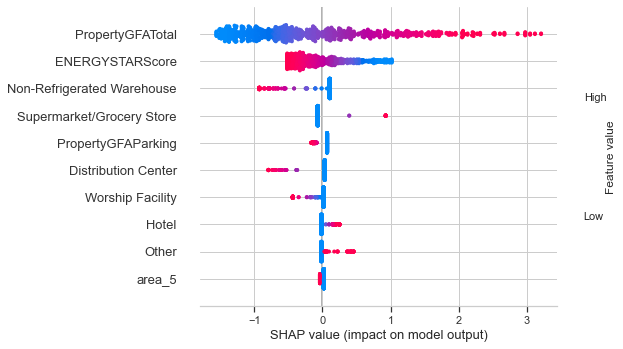

In [91]:
lin_reg_explainer2 = shap.LinearExplainer(grid_search11.best_estimator_[1], X_train_star_transformed)
shap.summary_plot(lin_reg_explainer2.shap_values(X_test_star_transformed),
                  features = X_test_star_transformed,max_display=10, feature_names= features_star, show=False)
plt.gcf().axes[-1].set_aspect(200)
plt.gcf().axes[-1].set_box_aspect(500)

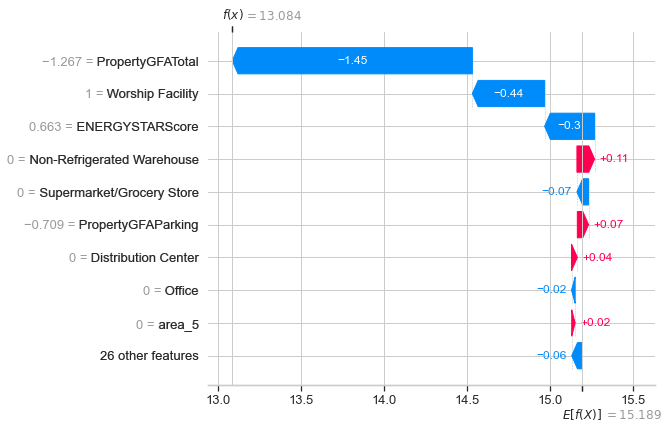

None


In [92]:
i = random.randint(1, len(X_test_star_transformed))
shap_values = lin_reg_explainer2(pd.DataFrame(X_test_star_transformed)[i-1:i])
shap_values.feature_names = features_star
print(shap.waterfall_plot(shap_values[0], max_display=10))